# Re-implementation of GBF in python

In [94]:
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scipy.io

import sys
sys.path.insert(0, '../baselines/gbf')
from gbf_utils import SARBM3D, SoftClassifier, GBF, SARDespeckling

print(jax.devices())

[CpuDevice(id=0)]


In [82]:
def rgb2gray(rgb):
    """Convert RGB image to grayscale."""
    return jnp.dot(rgb[..., :3], jnp.array([1./3.] * 3))


def T(sar: np.ndarray) -> np.ndarray:
    sar = jnp.array(sar)
    sar = 20 * np.log1p(np.abs(sar))
    sar = (sar - sar.min()) / (sar.max() - sar.min())  # Normalize to [0, 1]
    if sar.ndim == 2:
        sar = jnp.expand_dims(sar, axis=-1)  # (H, W) -> (H, W, 1)
    return sar


def invT(sar: np.ndarray, scale: float = 255.) -> np.ndarray:
    sar = jnp.array(sar)
    sar = sar * scale
    sar = jnp.expm1(sar / 20)
    return sar

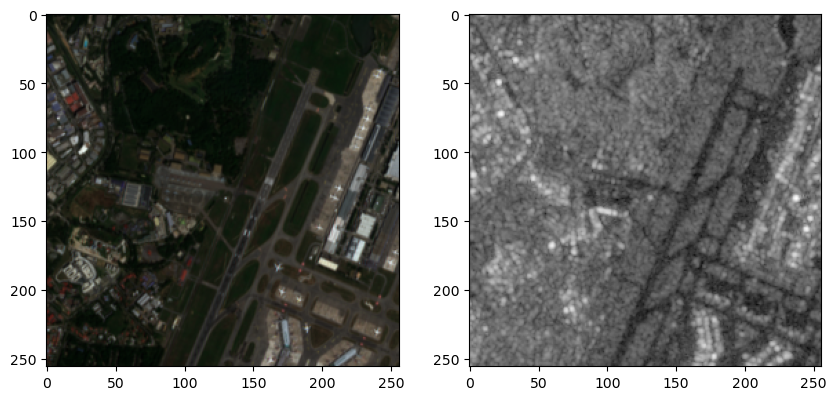

In [83]:
input_path = "../data/data.npz"
data = np.load(input_path)

eo = data['eo']
sar = data['sar']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(eo)
plt.subplot(1, 2, 2)
plt.imshow(sar, cmap='gray')

### Apply SARBM3D

In [84]:
sarbm3d = SARBM3D(matlab_script_path='./../../SARBM3D_v10_linux64/SARBM3D_v10.m')

sar_filtered_sarbm3d = sarbm3d.filter(invT(sar), L=1)

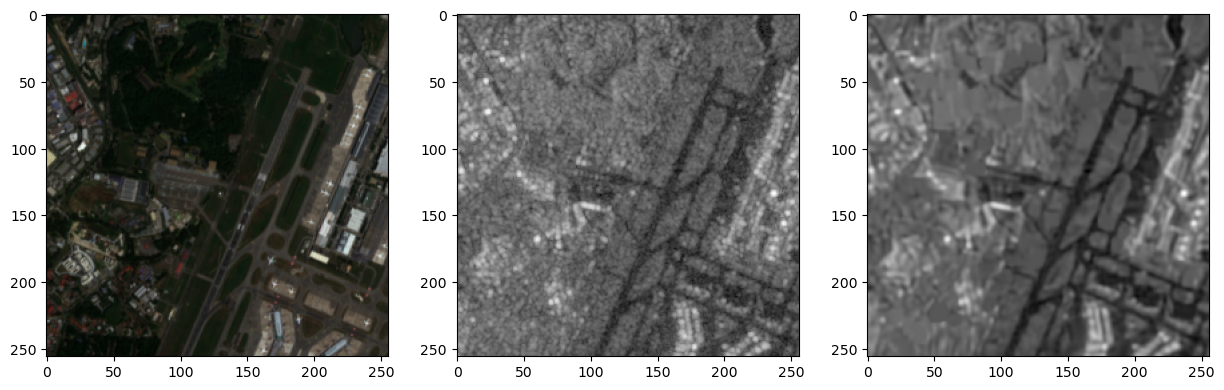

In [85]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(eo)
plt.subplot(1, 3, 2)
plt.imshow(sar, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(sar_filtered_sarbm3d, cmap='gray')

### Soft classifier 

In [86]:
soft_classifier = SoftClassifier()

weights = soft_classifier.compute_weight(invT(sar).squeeze(), N=np.arange(7, 35, 2).tolist())

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:01<00:00, 12.15it/s]


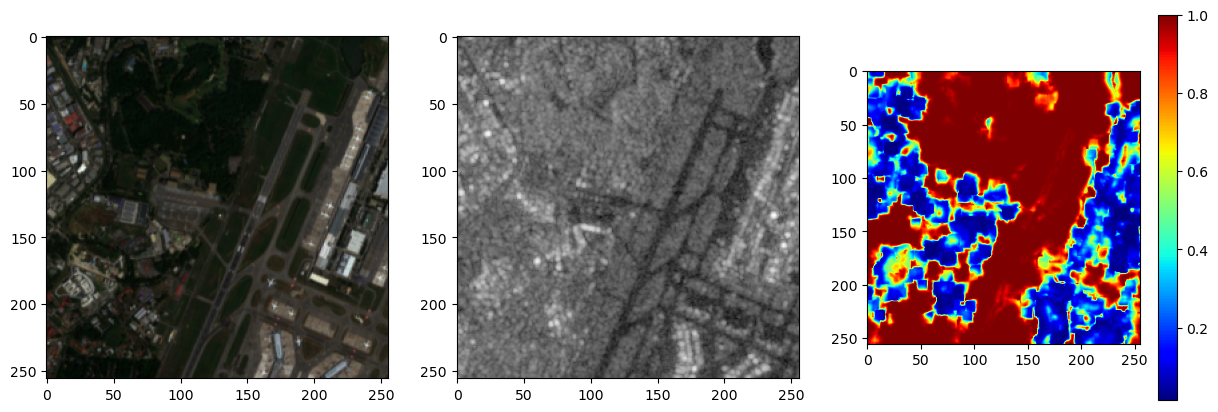

In [87]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(eo)
plt.subplot(1, 3, 2)
plt.imshow(sar, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(weights, cmap='jet')
plt.colorbar()

### GBF

In [122]:
gbf = GBF()

sar_filtered_gbf = gbf.filter(
    invT(sar).squeeze(), 
    rgb2gray(eo),
    window_size=31, 
    lambda_S=0.005, 
    lambda_RO=0.02, 
    lambda_RS=0.1
)

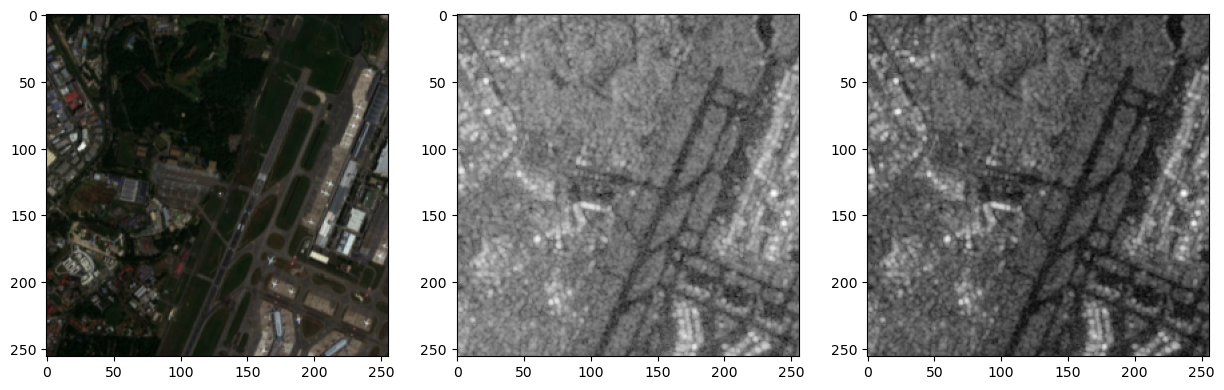

In [123]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(eo)
plt.subplot(1, 3, 2)
plt.imshow(T(sar), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(T(sar_filtered_gbf), cmap='gray')

### Despeckling

In [ ]:
uO = sar_filtered_gbf.squeeze()
uS = sar_filtered_sarbm3d.squeeze()
ft = weights

sar_despeckled = ft * uO + (1 - ft) * uS

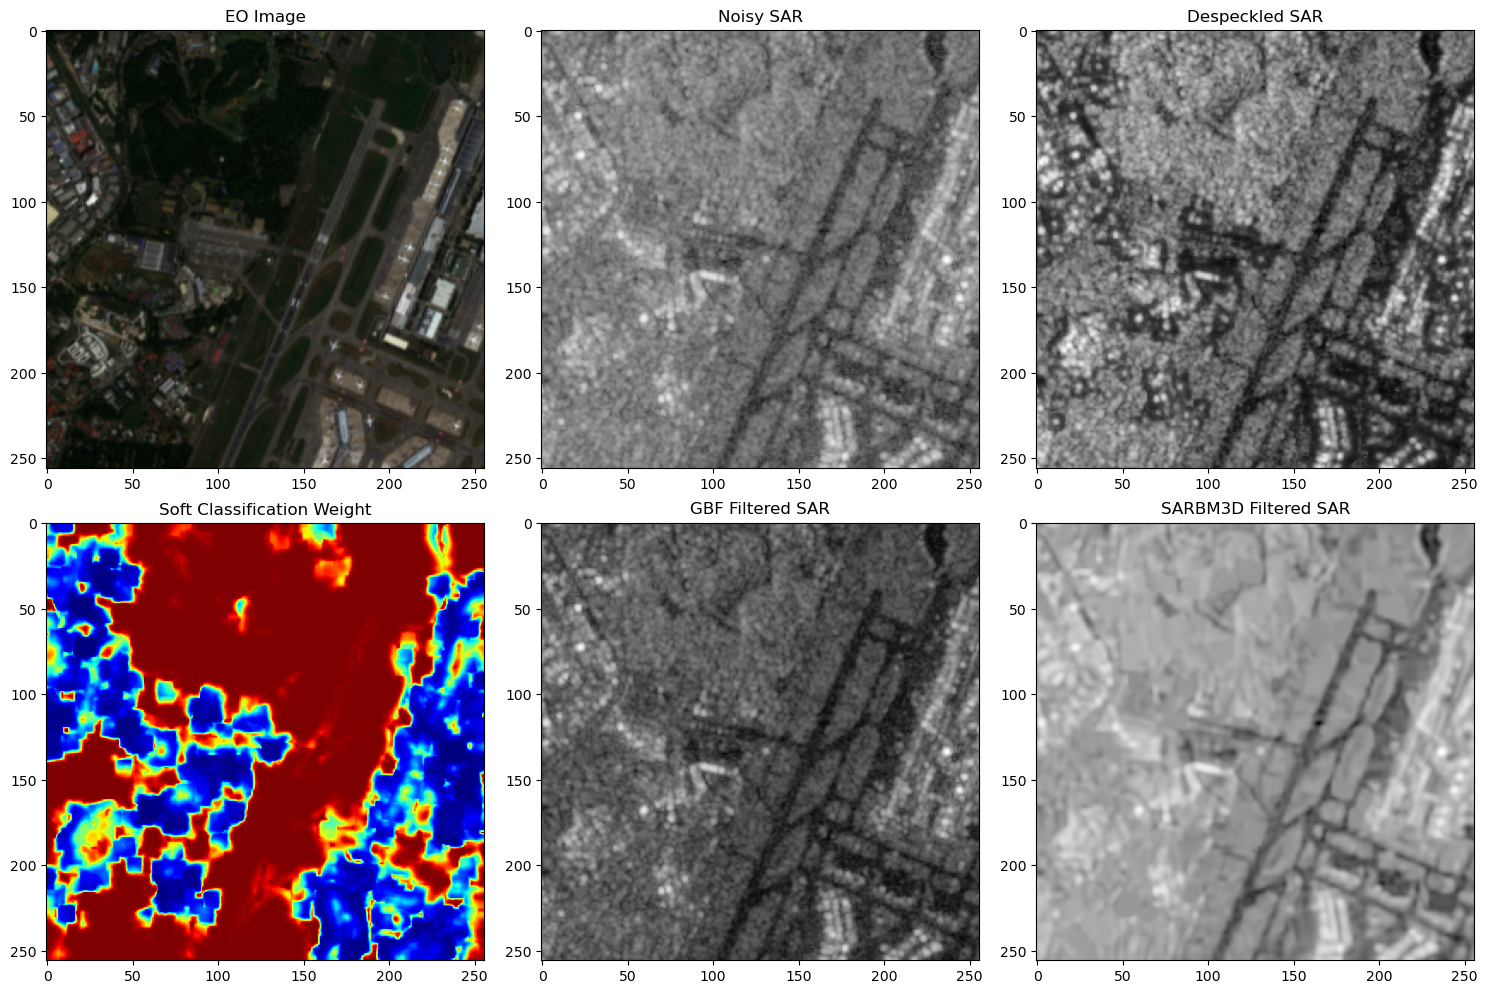

In [127]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.imshow(eo)
plt.title('EO Image')
plt.subplot(2, 3, 2)
plt.imshow(T(sar), cmap='gray')
plt.title('Noisy SAR')
plt.subplot(2, 3, 3)
plt.imshow(T(sar_despeckled), cmap='gray')
plt.title('Despeckled SAR')
plt.subplot(2, 3, 4)
plt.imshow(ft, cmap='jet')
plt.title('Soft Classification Weight')
plt.subplot(2, 3, 5)
plt.imshow(T(sar_filtered_gbf), cmap='gray')
plt.title('GBF Filtered SAR')
plt.subplot(2, 3, 6)
plt.imshow(T(sar_filtered_sarbm3d), cmap='gray')
plt.title('SARBM3D Filtered SAR')
plt.tight_layout()

In [100]:
# sar_despeckling = SARDespeckling()
# sar_despeckled = sar_despeckling.filter(
#     sar=invT(sar), 
#     opt=eo, 
#     matlab_script_path='./../../SARBM3D_v10_linux64/SARBM3D_v10.m',
#     L=1,
#     window_size=31, 
#     lambda_S=0.005, 
#     lambda_RO=0.02, 
#     lambda_RS=0.1,
#     N=np.arange(7, 63, 2),
#     gamma=7,
#     a0=0.64
# )

In [33]:
# import scipy
# from pathlib import Path

# def save_image(output_path: str, image: np.ndarray, key: str):
#     """Save an image to a file."""
#     plt.imsave(output_path.replace('.mat', '.png'), image.squeeze(), cmap='gray')  # Preview
#     scipy.io.savemat(output_path, {key: image})

In [ ]:
# save_image((Path.home() / 'workspace/despeckling/despeckling/results/output.mat').as_posix(), sar_filtered, 'sar_despeckled')
# save_image((Path.home() / 'workspace/despeckling/despeckling/baselines/tbog/results/output.mat').as_posix(), sar_filtered, 'sar_despeckled')